# Optimization Algorithms

In the previous experiment, we have explored some variations of Gradient Descent, particularly, __mini-Batch Gradient Descent (mBGD)__, and __Stochastic Gradient Descent (SGD)__. __Mini-batch Gradient Descent presents as a good alternative for Batch Gradient Descent__, mainly because of its computation efficiency. 

It turns out that Gradient Descent can further be improved by introducing more dynamic mechanism in adjusting ofweights. Think of the traditional GD (e.g. SGD, mBGD, BGD) as _velocity_ in a world governed by classical Physics. If there's _velocity_, then there should also be _acceleration_, _momentum_, and such!

In this notebook, we'll implement __Simple Moment__, __RMSprop__ and __Adam__ optimization algorithms. These 2 have been shown to work well across a wide range of deep learning architectures. 

* Adam: https://arxiv.org/abs/1412.6980
* RMSProp: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
from activation import relu, sigmoid, sigmoid_prime, softmax
from helper import one_hot_encoder
from initializer import initialize_weight
%matplotlib inline

from utils import dataloader
from losses import cross_entropy_loss

# Load Dataset
train_x, train_y = mnist.load_dataset(download=True, train=True)
test_x, test_y = mnist.load_dataset(download=True, train=False)

Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz
Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz
Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz
Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz


## 1st Moment

Here are the equations of weight updates using moment:

Keypoints of optimization using moments:

1. Moment takes into account the __history of gradient values__. This helps the algorithm in choosing whether to speed up or slow down the gradient descent, and therefore, smoothing the optimization.
2. Usual values of beta ranges from __0.8 to 0.999__. The most common value of beta is __0.9__. However, __loss is exploding__, consider using smaller values of beta, around __0.1 to 0.2__.
3. One way of checking if your implementation of moment is correct is by setting the beta value to 0. Setting the beta value to 0 is the same as performing normal gradient descent.
4. Also, the end values of moment are multiplied by (1-beta_1). This is done to normalize the moments, and to avoid explosion of moment values and gradient updates.

In [93]:
def train_moment(train_x, train_y, learning_rate=0.1, num_epochs=50, batch_size=1):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    # Initialize Moments
    v_w1, v_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    v_w2, v_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    
    # Optimizer Hyperparameters
    beta_1 = 0.9
    
    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # 1st Moment
            v_w2 += (beta_1 * v_w2 + (1-beta_1) * dw2) * (1-beta_1)
            v_b2 += (beta_1 * v_b2 + (1-beta_1) * db2) * (1-beta_1)
            v_w1 += (beta_1 * v_w1 + (1-beta_1) * dw1) * (1-beta_1)
            v_b1 += (beta_1 * v_b1 + (1-beta_1) * db1) * (1-beta_1)
            
            # Weight (and bias) update
            w1 -= learning_rate * v_w1
            b1 -= learning_rate * v_b1
            w2 -= learning_rate * v_w2
            b2 -= learning_rate * v_b2
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [112]:
w1_m, b1_m, w2_m, b2_m, loss_history_m = train_moment(train_x, train_y, learning_rate=5, num_epochs=20, batch_size=None)

Epoch 1/20
Loss: 2.499727
Accuracy: 6.87%

Epoch 2/20
Loss: 2.259785
Accuracy: 16.03%

Epoch 3/20
Loss: 1.989637
Accuracy: 36.00%

Epoch 4/20
Loss: 1.766470
Accuracy: 45.96%

Epoch 5/20
Loss: 1.481157
Accuracy: 58.89%

Epoch 6/20
Loss: 1.217915
Accuracy: 70.73%

Epoch 7/20
Loss: 1.086503
Accuracy: 69.41%

Epoch 8/20
Loss: 1.017676
Accuracy: 69.73%

Epoch 9/20
Loss: 0.926689
Accuracy: 71.26%

Epoch 10/20
Loss: 0.794818
Accuracy: 77.99%

Epoch 11/20
Loss: 0.701527
Accuracy: 80.54%

Epoch 12/20
Loss: 0.701453
Accuracy: 76.54%

Epoch 13/20
Loss: 0.699908
Accuracy: 75.22%

Epoch 14/20
Loss: 0.648807
Accuracy: 78.19%

Epoch 15/20
Loss: 0.601688
Accuracy: 80.55%

Epoch 16/20
Loss: 0.593441
Accuracy: 80.47%

Epoch 17/20
Loss: 0.606569
Accuracy: 80.04%

Epoch 18/20
Loss: 0.619384
Accuracy: 79.85%

Epoch 19/20
Loss: 0.619886
Accuracy: 80.44%

Epoch 20/20
Loss: 0.599690
Accuracy: 81.44%



# RMSProp: 2nd Moment

Keypoints:

1. Usual values of 2nd moment beta is 0.999. Similar to 1st moment, if the loss value is exploding, consider exploring smaller values of beta, __0.1 to 0.2__.

In [89]:
def train_rmsprop(train_x, train_y, learning_rate=0.1, num_epochs=50, batch_size=1):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    # Initialize Moments
    s_w1, s_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    s_w2, s_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    
    # Optimizer Hyperparameters
    beta_2 = 0.1
    epsilon = 1e-8
    
    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)
            
            # 2nd Moment
            s_w2 += beta_2 * s_w2 + (1-beta_2) * dw2 * dw2
            s_b2 += beta_2 * s_b2 + (1-beta_2) * db2 * db2
            s_w1 += beta_2 * s_w1 + (1-beta_2) * dw1 * dw1
            s_b1 += beta_2 * s_b1 + (1-beta_2) * db1 * db1
            
            # Weight (and bias) update
            w1 -= learning_rate * dw1 / (np.sqrt(s_w1) + epsilon)
            b1 -= learning_rate * db1 / (np.sqrt(s_b1) + epsilon)
            w2 -= learning_rate * dw2 / (np.sqrt(s_w2) + epsilon)
            b2 -= learning_rate * db2 / (np.sqrt(s_b2) + epsilon)
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [90]:
w1_r, b1_r, w2_r, b2_r, loss_history_r = train_rmsprop(train_x, train_y, learning_rate=0.03, num_epochs=20, batch_size=None)

Epoch 1/20
Loss: 2.451064
Accuracy: 9.40%

Epoch 2/20
Loss: 3.751505
Accuracy: 26.60%

Epoch 3/20
Loss: 2.553249
Accuracy: 35.91%

Epoch 4/20
Loss: 1.992432
Accuracy: 26.72%

Epoch 5/20
Loss: 1.360959
Accuracy: 63.41%

Epoch 6/20
Loss: 1.003484
Accuracy: 73.29%

Epoch 7/20
Loss: 0.841040
Accuracy: 80.51%

Epoch 8/20
Loss: 0.760839
Accuracy: 80.98%

Epoch 9/20
Loss: 0.711033
Accuracy: 82.06%

Epoch 10/20
Loss: 0.669831
Accuracy: 81.37%

Epoch 11/20
Loss: 0.630463
Accuracy: 83.52%

Epoch 12/20
Loss: 0.598039
Accuracy: 84.23%

Epoch 13/20
Loss: 0.562777
Accuracy: 85.62%

Epoch 14/20
Loss: 0.531652
Accuracy: 87.06%

Epoch 15/20
Loss: 0.508211
Accuracy: 87.57%

Epoch 16/20
Loss: 0.491475
Accuracy: 88.20%

Epoch 17/20
Loss: 0.477901
Accuracy: 88.31%

Epoch 18/20
Loss: 0.464282
Accuracy: 89.02%

Epoch 19/20
Loss: 0.453246
Accuracy: 89.02%

Epoch 20/20
Loss: 0.441257
Accuracy: 89.52%



# Adam: Moment + RMSProp

Keypoints:

1. Usual values of 1st moment beta is 0.9. If loss value is exploding, consding using smaller values of beta_1, __0.1 to 0.2__.
2. Usual values of 2nd moment beta is 0.999. Similar to 1st moment, if the loss value is exploding, consider exploring smaller values of beta, __0.1 to 0.2__.

In [116]:
def train_adam(train_x, train_y, learning_rate=0.1, num_epochs=50, batch_size=1):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    # Initialize Moments
    s_w1, s_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    s_w2, s_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    v_w1, v_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    v_w2, v_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    
    # Optimizer Hyperparameters
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    
    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # 1st Moment
            v_w2 += (beta_1 * v_w2 + (1-beta_1) * dw2) * (1-beta_1)
            v_b2 += (beta_1 * v_b2 + (1-beta_1) * db2) * (1-beta_1)
            v_w1 += (beta_1 * v_w1 + (1-beta_1) * dw1) * (1-beta_1)
            v_b1 += (beta_1 * v_b1 + (1-beta_1) * db1) * (1-beta_1)
            
            # 2nd Moment
            s_w2 += beta_2 * s_w2 + (1-beta_2) * dw2 * dw2
            s_b2 += beta_2 * s_b2 + (1-beta_2) * db2 * db2
            s_w1 += beta_2 * s_w1 + (1-beta_2) * dw1 * dw1
            s_b1 += beta_2 * s_b1 + (1-beta_2) * db1 * db1
            
            # Weight (and bias) update
            w1 -= learning_rate * v_w1 / (np.sqrt(s_w1) + epsilon)
            b1 -= learning_rate * v_b1 / (np.sqrt(s_b1) + epsilon)
            w2 -= learning_rate * v_w2 / (np.sqrt(s_w2) + epsilon)
            b2 -= learning_rate * v_b2 / (np.sqrt(s_b2) + epsilon)
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [117]:
w1_a, b1_a, w2_a, b2_a, loss_history_a = train_adam(train_x, train_y, learning_rate=0.05, num_epochs=20, batch_size=None)

Epoch 1/20
Loss: 2.479033
Accuracy: 8.82%

Epoch 2/20
Loss: 2.490571
Accuracy: 40.64%

Epoch 3/20
Loss: 1.928845
Accuracy: 40.61%

Epoch 4/20
Loss: 1.440993
Accuracy: 54.83%

Epoch 5/20
Loss: 1.231084
Accuracy: 61.09%

Epoch 6/20
Loss: 1.045811
Accuracy: 68.71%

Epoch 7/20
Loss: 0.991372
Accuracy: 68.72%

Epoch 8/20
Loss: 0.991418
Accuracy: 64.59%

Epoch 9/20
Loss: 0.960341
Accuracy: 65.66%

Epoch 10/20
Loss: 0.901249
Accuracy: 69.18%

Epoch 11/20
Loss: 0.840465
Accuracy: 73.43%

Epoch 12/20
Loss: 0.793125
Accuracy: 76.74%

Epoch 13/20
Loss: 0.759425
Accuracy: 79.05%

Epoch 14/20
Loss: 0.736940
Accuracy: 80.48%

Epoch 15/20
Loss: 0.721291
Accuracy: 81.19%

Epoch 16/20
Loss: 0.710650
Accuracy: 81.58%

Epoch 17/20
Loss: 0.703202
Accuracy: 81.75%

Epoch 18/20
Loss: 0.697766
Accuracy: 81.82%

Epoch 19/20
Loss: 0.693648
Accuracy: 81.81%

Epoch 20/20
Loss: 0.690613
Accuracy: 81.78%



# Vanilla Gradient Descent

In [109]:
def train(train_x, train_y, learning_rate=0.1, num_epochs=50, batch_size=1):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # Weight (and bias) update
            w1 -= learning_rate * dw1
            b1 -= learning_rate * db1
            w2 -= learning_rate * dw2
            b2 -= learning_rate * db2
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [110]:
w1_mbgd, b1_mbgd, w2_mbgd, b2_mbgd, loss_history_mbgd = train(train_x, train_y, learning_rate=0.1, num_epochs=20, batch_size=64)

Epoch 1/20
Loss: 0.558154
Accuracy: 84.84%

Epoch 2/20
Loss: 0.416693
Accuracy: 88.19%

Epoch 3/20
Loss: 0.402427
Accuracy: 88.27%

Epoch 4/20
Loss: 0.393966
Accuracy: 88.52%

Epoch 5/20
Loss: 0.371888
Accuracy: 89.05%

Epoch 6/20
Loss: 0.382685
Accuracy: 88.61%

Epoch 7/20
Loss: 0.377994
Accuracy: 88.70%

Epoch 8/20
Loss: 0.368225
Accuracy: 88.93%

Epoch 9/20
Loss: 0.351254
Accuracy: 89.37%

Epoch 10/20
Loss: 0.338220
Accuracy: 89.78%

Epoch 11/20
Loss: 0.349975
Accuracy: 89.31%

Epoch 12/20
Loss: 0.347572
Accuracy: 89.39%

Epoch 13/20
Loss: 0.331467
Accuracy: 89.98%

Epoch 14/20
Loss: 0.326367
Accuracy: 89.98%

Epoch 15/20
Loss: 0.378978
Accuracy: 88.45%

Epoch 16/20
Loss: 0.349324
Accuracy: 89.44%

Epoch 17/20
Loss: 0.328329
Accuracy: 90.21%

Epoch 18/20
Loss: 0.324067
Accuracy: 90.15%

Epoch 19/20
Loss: 0.320786
Accuracy: 90.16%

Epoch 20/20
Loss: 0.334086
Accuracy: 89.84%



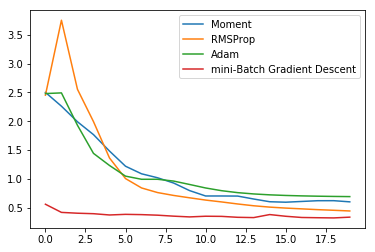

In [118]:
# Plot Losses
plt.plot(loss_history_m, label="Moment")
plt.plot(loss_history_r, label="RMSProp")
plt.plot(loss_history_a, label="Adam")
plt.plot(loss_history_mbgd, label="mini-Batch Gradient Descent")
plt.legend()